In [1]:
import random
import math
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import KFold
from scipy import stats

DATA_PATH = os.path.abspath('data')

def normalEquation_ridge(matX,vecY,lamda):
    X_transpose = np.transpose(matX)
    X_transpose_dot_X = np.dot(X_transpose,matX)
    
    diagonal_one = np.identity(X_transpose_dot_X.shape[0])
    diagonal_one[0,0] = 0

    left_side = X_transpose_dot_X + lamda*diagonal_one
    right_side = np.dot(X_transpose,vecY)

    ans = np.linalg.inv(left_side).dot(right_side)
    return ans

def generate_feature_matrix(x, degree):
    if degree == 0:
        X = np.ones((len(x), 1))
        return X
    elif degree == 1:
        X = np.column_stack((np.ones(len(x)), x))
        return X
    elif degree > 1:
        X_poly = np.column_stack([x ** d for d in range(0, degree+1)])
        return X_poly
    else:
        raise ValueError("Degree must be a non-negative integer.")
    
def Standardize(points):
    a = 0
    n = len(points)
    mean = sum(points) / n
    new_points = []
    for i in range(0,n):
        a += (points[i] - mean) ** 2
    std = math.sqrt(a / (n-1))
    for i in range(0,n):
        new_points.append((points[i] - mean) / std)
    return new_points

def CalculateSE_ridge(x_positions, y_positions, w_list, lamda):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list)-1)
    SE = 0
    for i in range(0, n):
        wx = np.dot(x_positions[i],w_list)
        SE += ((wx - y_positions[i]) ** 2)

    for j in range(len(w_list)):
        SE += lamda*w_list[j]**2
        
    return SE

def draw_regression_line(w,name,x):
    x_line = np.linspace(min(x),max(x), 100)
    y_line = w[1] * x_line + w[0]

    regression = go.Scatter(x=x_line, y=y_line, mode='lines', name=name)
    return regression

def polynomial_predictions(x, w):
    degree = len(w) - 1
    y_pred = np.zeros_like(x)
    for i in range(degree + 1):
        y_pred += w[i] * (x**i)
    return y_pred

def model_plot(x, y, w_list, label_list):
    fig = go.Figure()
    x_range = np.linspace(min(x), max(x), 100)

    for i, w in enumerate(w_list):
        y_pred = polynomial_predictions(x_range, w)
        fig.add_trace(go.Scatter(x=x_range, y=y_pred, mode='lines', name=label_list[i]))

    fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Data Points', marker=dict(color='blue')))
    #y_sin = [math.sin(math.pi*x) for x in x_range]
    #fig.add_trace(go.Scatter(x=x_range, y=y_sin, mode='lines', name="sin"))

    fig.update_layout(
        title=f'Data and Polynomial Regression {len(x)} Samples',
        xaxis_title='X',
        yaxis_title='Y',
        showlegend=True,
        width=1000,
        height=600,
        yaxis_range=[-1.5,1.5]
    )

    return fig

def CalculateMSE(x_positions, y_positions, w_list):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list)-1)
    MSE = 0

    for i in range(0, n):
        wx = np.dot(x_positions[i], w_list) #x_positon is array 1 x len(w_list) dimension Ex. [ 1 , x^1 , x^2 , ..... , x^n]
        MSE += (wx - y_positions[i]) ** 2

        
    MSE *= 1/(n)
    # print("new",MSE)
    return MSE

def cross_validation(X, y, folds, degree, lamda):
    #Not done
    k_folds = KFold(n_splits=folds)
    
    avg_rmse = []
    for train_index, validate_index in k_folds.split(X):
        # print(train_index,validate_index)
        X_train , X_validate = X.iloc[train_index], X.iloc[validate_index]
        y_train , y_validate = y.iloc[train_index], y.iloc[validate_index]

        x_feature_matrix = generate_feature_matrix(X_train.values.flatten(), degree)
        result = normalEquation_ridge(x_feature_matrix, np.array(y_train), lamda)
        
        avg_rmse.append(CalculateMSE(X_validate.values.flatten(), np.array(y_validate), result)**(1/2))
        #avg_rmse.append(CalculateMSE_poly(X_validate.values.flatten(), np.array(y_validate), result))
    return np.mean(avg_rmse)

def Standardize(points):
    a = 0
    n = len(points)
    mean = sum(points) / n
    new_points = []
    for i in range(0,n):
        a += (points[i] - mean) ** 2
    std = math.sqrt(a / (n-1))
    for i in range(0,n):
        new_points.append((points[i] - mean) / std)
    return new_points

def random_linear_model(target_func, n=2, noisy=0, sigma=0.1, seed=1):
    mu = 0 # mean and standard deviation
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma, n)
    x = [float(random.uniform(-1.0,1.0)) for i in range(n)]
    y = target_func(x, noise, noisy)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return (float(intercept), float(slope), x, y)

def random_linear_model_ridge(target_func, n=2,  noisy=0, sigma=0.1, seed=1, lamda=0, degree=1):
    mu = 0 # mean and standard deviation
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma, n)
    x = [float(random.uniform(-1.0,1.0)) for i in range(n)]
    y = target_func(x, noise, noisy)
    x_feature_matrix = generate_feature_matrix(x, degree)
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    return w

def abline(slope, intercept, color, linewidth = 0.1):
    """Plot a line from slope and intercept"""
    x_vals = np.linspace(-1, 1, 1000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=color, linewidth = linewidth)

def var_one_model(slope, intercept, slope_avg, intercept_avg):
    # only one model
    x_vals = np.linspace(-1, 1, 1000)
    var_list = []
    for x in x_vals:
        y_model = slope*x + intercept
        y_avg = slope_avg*x + intercept_avg
        var_list.append((y_model - y_avg)**2)
    return np.array(var_list)

def var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg):
    variance_list = []
    var_list = []
    for i in range(len(slope_sample)):
        slope = slope_sample[i]
        intercept = intercept_sample[i]
        var = var_one_model(slope, intercept, slope_avg, intercept_avg)
        var_list.append(var)
        variance_list.append(np.average(var))
    return variance_list , sum(var_list)/len(var_list)

def bias_linear_model(slope_avg,intercept_avg,target_func):
    x_vals = np.linspace(-1, 1, 1000)
    bias = 0
    for x in x_vals:
        bias += ((slope_avg*x + intercept_avg) - target_func([x],[0],0)[0])**2
    bias /= len(x_vals)
    return bias

In [2]:
def sin_pi(x, noise, noisy):
    return [math.sin(x[i]*math.pi)+(noise[i]*noisy) for i in range(len(x))]

def new_func(x, noise, noisy):
    return [(1/2) * abs(math.sin(2 * x[i] * math.pi)) + 0.25*x[i] + 0.25 + +(noise[i]*noisy) for i in range(len(x))]

def cos_pi(x, noise, noisy):
    return [math.cos(x[i]*math.pi)+(noise[i]*noisy) for i in range(len(x))]

# ข้อ 1

In [3]:
# Plot sample data
df = pd.read_csv(os.path.join(DATA_PATH, "sin_noiseless.csv"))

# Sample some point with uniform pick
NUMBER_OF_POINT = 15
sample_index = np.floor(np.linspace(0, len(df['x'])-1, NUMBER_OF_POINT))
x = np.array([df['x'][i] for i in sample_index])
y = np.array([df['y'][i] for i in sample_index])

data = go.Scatter(x=x, y=y,mode='markers')
fig = go.Figure(data=[data])
fig.show()

In [4]:
# Draw regresstion line for each lambda

x_feature_matrix = generate_feature_matrix(x, 1)
w_lamda_0 = normalEquation_ridge(x_feature_matrix, y, 0)
w_lamda_10 = normalEquation_ridge(x_feature_matrix, y, 10)
w_lamda_20 = normalEquation_ridge(x_feature_matrix, y, 20)
w_lamda_40 = normalEquation_ridge(x_feature_matrix, y, 40)
w_lamda_400 = normalEquation_ridge(x_feature_matrix, y, 400)

data = go.Scatter(x=x, y=y,mode='markers')

regression1 = draw_regression_line(w_lamda_0,"w_lamda_0",x)
regression2 = draw_regression_line(w_lamda_10,"w_lamda_10",x)
regression3 = draw_regression_line(w_lamda_20,"w_lamda_20",x)
regression4 = draw_regression_line(w_lamda_40,"w_lamda_40",x)
regression5 = draw_regression_line(w_lamda_400,"w_lamda_400",x)

fig = go.Figure(data=[data, regression1, regression2, regression3, regression4, regression5])
fig.show()

In [5]:
#  Cost function graph
w_plot = np.linspace(-0.5, 3, 1000)
lamda_list = [0, 10, 20, 40, 400]
all_line = []

for lamda in lamda_list:
    SE_plot = []
    for w in w_plot:
        cost_function = CalculateSE_ridge(x, y, np.array([0,w]), lamda)
        SE_plot.append(cost_function)
    
    # Create cost function line
    line = go.Scatter(x=w_plot, y=SE_plot,mode='lines', name=f'lamda {lamda}')
    all_line.append(line)

fig = go.Figure(data=all_line)
fig.update_layout(yaxis_range=[0,20])
fig.show()

# ข้อ 2

In [6]:
# Sample some point with uniform pick
NUMBER_OF_POINT = 10
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

data = go.Scatter(x=x, y=y,mode='markers')
fig = go.Figure(data=[data])
fig.show()

In [7]:
# lambda = 0
DEGREE = 9
lamda_list = [0, math.e**(-18), math.e**(-10), math.e**(-5), 1]
label_list = [f'lambda = {lamda}' for lamda in lamda_list]
w_list = []
for lamda in lamda_list:
    x_feature_matrix = generate_feature_matrix(x, DEGREE)
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)

fig = model_plot(x, y, w_list, label_list)

# sin graph
x_sin = np.linspace(0, 1, 10000)
data = go.Scatter(x=x_sin, y=np.sin(2*x_sin*math.pi),mode='lines', name='Sin')
fig.add_trace(data)
fig.show()

In [8]:
# sample 100

# Sample some point with uniform pick
NUMBER_OF_POINT = 100
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

DEGREE = 9
FOLDS = 10
NUMBER_OF_SEEDS = 20
log_e_lamda = np.linspace(-40, 10, 100)
lamda_list = np.vectorize(math.exp)(log_e_lamda)
# lamda_list = np.linspace(0, 100, 100)

w_list = []
E_test = []
E_train = []

df = pd.DataFrame({'x':x, 'y':y})
x_feature_matrix = generate_feature_matrix(x, DEGREE)

for lamda in lamda_list:
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)
    E_train.append(CalculateMSE(x, y, w)**(1/2))
    E_test_avg = 0
    for seed in range(NUMBER_OF_SEEDS):
        df_test = df.sample(frac=1, random_state=seed, ignore_index=True)
        E_test_avg += cross_validation(df_test['x'], df_test['y'], FOLDS, DEGREE, lamda)
    E_test.append(E_test_avg/NUMBER_OF_SEEDS)

fig = go.Figure()
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_test ,mode='lines', name='E_test'))
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_train ,mode='lines', name='E_train'))
fig.update_layout(
    yaxis_range=[0,1],
    title=f'Sample = 100, Degree = 9',
    xaxis_title='ln lambda',
    yaxis_title='E_RMSE',
    )
fig.show()


In [9]:
# Sample some point with uniform pick
NUMBER_OF_POINT = 10
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

DEGREE = 9
FOLDS = 10
NUMBER_OF_SEEDS = 20
log_e_lamda = np.linspace(-40, 10, 100)
lamda_list = np.vectorize(math.exp)(log_e_lamda)
# lamda_list = np.linspace(0, 100, 100)

w_list = []
E_test = []
E_train = []

df = pd.DataFrame({'x':x, 'y':y})
x_feature_matrix = generate_feature_matrix(x, DEGREE)

for lamda in lamda_list:
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)
    E_train.append(CalculateMSE(x, y, w)**(1/2))
    E_test_avg = 0
    for seed in range(NUMBER_OF_SEEDS):
        df_test = df.sample(frac=1, random_state=seed, ignore_index=True)
        E_test_avg += cross_validation(df_test['x'], df_test['y'], FOLDS, DEGREE, lamda)
    E_test.append(E_test_avg/NUMBER_OF_SEEDS)

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_test ,mode='lines', name='E_test'))
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_train ,mode='lines', name='E_train'))
fig.update_layout(
    title=f'DEGREE = 9',
    xaxis_title='ln lambda',
    yaxis_title='E_RMSE',
    yaxis_range=[0,1]
    )
fig.show()

In [11]:
# Sample some point with uniform pick
NUMBER_OF_POINT = 10
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

DEGREE = 1
FOLDS = 10
NUMBER_OF_SEEDS = 20
log_e_lamda = np.linspace(-40, 10, 100)
lamda_list = np.vectorize(math.exp)(log_e_lamda)
# lamda_list = np.linspace(0, 100, 100)

w_list = []
E_test = []
E_train = []

df = pd.DataFrame({'x':x, 'y':y})
x_feature_matrix = generate_feature_matrix(x, DEGREE)

for lamda in lamda_list:
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)
    E_train.append(CalculateMSE(x, y, w)**(1/2))
    E_test_avg = 0
    for seed in range(NUMBER_OF_SEEDS):
        df_test = df.sample(frac=1, random_state=seed, ignore_index=True)
        E_test_avg += cross_validation(df_test['x'], df_test['y'], FOLDS, DEGREE, lamda)
    E_test.append(E_test_avg/NUMBER_OF_SEEDS)

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_test ,mode='lines', name='E_test'))
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_train ,mode='lines', name='E_train'))
fig.update_layout(
    title=f'DEGREE = 1',
    xaxis_title='ln lambda',
    yaxis_title='E_RMSE',
    )
fig.show()

In [13]:
# Sample some point with uniform pick
NUMBER_OF_POINT = 10
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

DEGREE = 3
FOLDS = 10
NUMBER_OF_SEEDS = 20
log_e_lamda = np.linspace(-40, 10, 100)
lamda_list = np.vectorize(math.exp)(log_e_lamda)
# lamda_list = np.linspace(0, 100, 100)

w_list = []
E_test = []
E_train = []

df = pd.DataFrame({'x':x, 'y':y})
x_feature_matrix = generate_feature_matrix(x, DEGREE)

for lamda in lamda_list:
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)
    E_train.append(CalculateMSE(x, y, w)**(1/2))
    E_test_avg = 0
    for seed in range(NUMBER_OF_SEEDS):
        df_test = df.sample(frac=1, random_state=seed, ignore_index=True)
        E_test_avg += cross_validation(df_test['x'], df_test['y'], FOLDS, DEGREE, lamda)
    E_test.append(E_test_avg/NUMBER_OF_SEEDS)

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_test ,mode='lines', name='E_test'))
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_train ,mode='lines', name='E_train'))
fig.update_layout(
    title=f'DEGREE = 3',
    xaxis_title='ln lambda',
    yaxis_title='E_RMSE',
    )
fig.show()

In [15]:
# Sample some point with uniform pick
NUMBER_OF_POINT = 10
np.random.seed(1)
x = np.linspace(0, 1, NUMBER_OF_POINT)
y = np.sin(2*math.pi*x) + np.random.normal(0, 0.2, NUMBER_OF_POINT)

DEGREE = 5
FOLDS = 10
NUMBER_OF_SEEDS = 20
log_e_lamda = np.linspace(-40, 10, 100)
lamda_list = np.vectorize(math.exp)(log_e_lamda)
# lamda_list = np.linspace(0, 100, 100)

w_list = []
E_test = []
E_train = []

df = pd.DataFrame({'x':x, 'y':y})
x_feature_matrix = generate_feature_matrix(x, DEGREE)

for lamda in lamda_list:
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    w_list.append(w)
    E_train.append(CalculateMSE(x, y, w)**(1/2))
    E_test_avg = 0
    for seed in range(NUMBER_OF_SEEDS):
        df_test = df.sample(frac=1, random_state=seed, ignore_index=True)
        E_test_avg += cross_validation(df_test['x'], df_test['y'], FOLDS, DEGREE, lamda)
    E_test.append(E_test_avg/NUMBER_OF_SEEDS)

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_test ,mode='lines', name='E_test'))
fig.add_trace(go.Scatter(x=log_e_lamda, y=E_train ,mode='lines', name='E_train'))
fig.update_layout(
    title=f'DEGREE = 5',
    xaxis_title='ln lambda',
    yaxis_title='E_RMSE',
    )
fig.show()

# ข้อ 3

In [17]:
# without Regularize
# Pick 2 random points to create n models and average them
n = 5000
slope_sample = []
intercept_sample = []
for i in range(n):
    intercept, slope = random_linear_model(sin_pi)[0:2]
    slope_sample.append(slope)
    intercept_sample.append(intercept)

In [18]:
slope_avg = np.average(slope_sample)
intercept_avg = np.average(intercept_sample)
print("slope_avg:", slope_avg)
print("intercept_avg:", intercept_avg)

slope_avg: 0.752167769676586
intercept_avg: 0.0020584492149382594


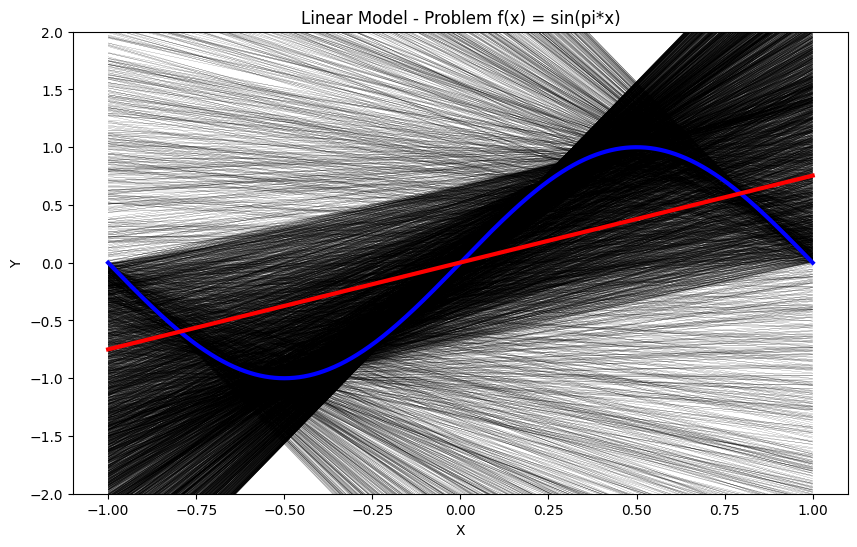

In [19]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model - Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], intercept_sample[i], 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [20]:
var_linear_model_list = var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)
bias = bias_linear_model(slope_avg, intercept_avg, sin_pi)
print("var:", np.average(var_linear_model_list[0]))
print("bias:", bias)

var: 1.6835585993129492
bias: 0.2101027843858851


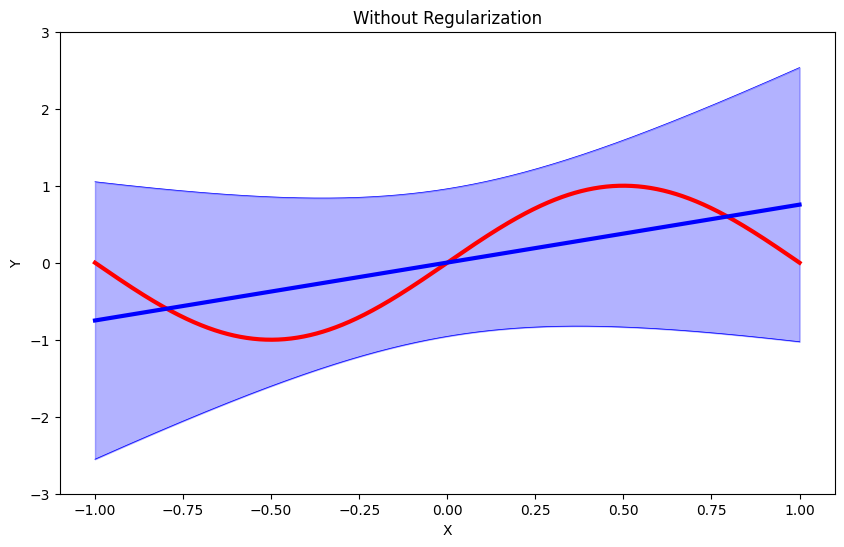

In [21]:
plt.figure(figsize=(10,6))
plt.ylim(-3,3)
plt.title("Without Regularization")
plt.xlabel("X")
plt.ylabel("Y")

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'b', 3)
g_bar = intercept_avg + slope_avg * x_vals

var1 = (var_linear_model_list[1]**(1/2)) + np.array(g_bar)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(g_bar) - (var_linear_model_list[1]**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)
#plt.fill_between(x_vals, var1, color='b', alpha=0.5)

In [22]:
# with Regularize
# Pick 2 random points to create n models and average them
n = 5000
slope_sample = []
intercept_sample = []
for i in range(n):
    intercept, slope = random_linear_model_ridge(sin_pi, lamda = math.exp(-2))[0:2]
    slope_sample.append(slope)
    intercept_sample.append(intercept)

In [23]:
slope_avg = np.average(slope_sample)
intercept_avg = np.average(intercept_sample)
print("slope_avg:", slope_avg)
print("intercept_avg:", intercept_avg)

slope_avg: 0.49690396595854164
intercept_avg: -0.019111296022379046


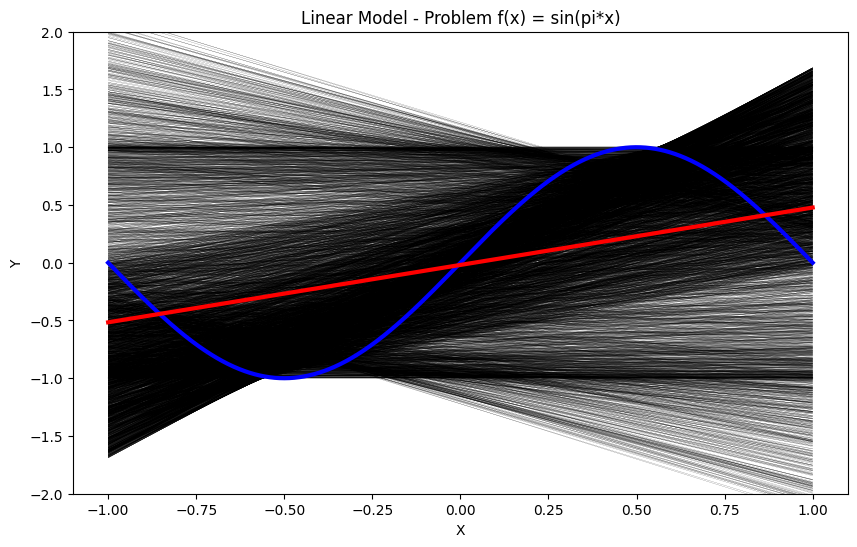

In [24]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model - Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], intercept_sample[i], 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals, [0]*points_amt, 0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [25]:
var_linear_model_list = var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)
bias = bias_linear_model(slope_avg, intercept_avg, sin_pi)
print("var:", np.average(var_linear_model_list[0]))
print("bias:", bias)

var: 0.45347145312291615
bias: 0.26631302352045905


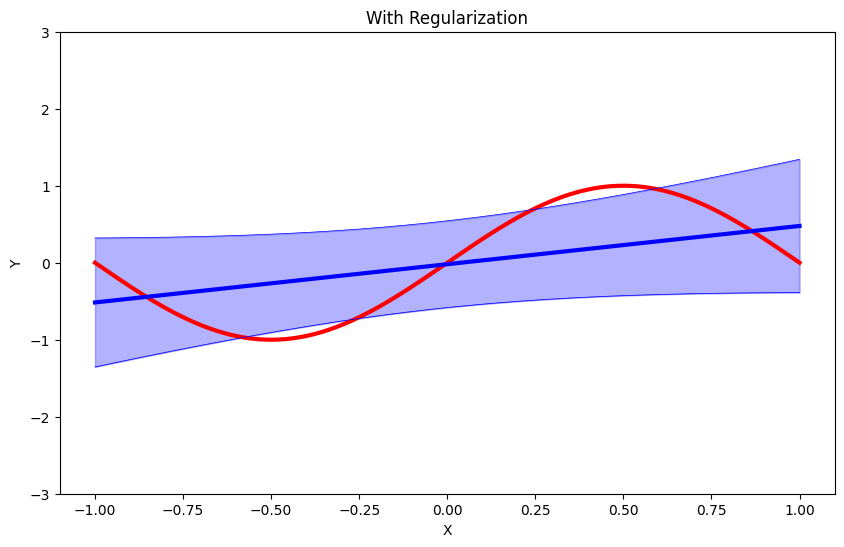

In [26]:
plt.figure(figsize=(10,6))
plt.ylim(-3,3)
plt.title("With Regularization")
plt.xlabel("X")
plt.ylabel("Y")

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, 1000)
y_vals = sin_pi(x_vals, [0]*points_amt, 0)
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'b', 3)
g_bar = intercept_avg + slope_avg * x_vals

var1 = (var_linear_model_list[1]**(1/2)) + np.array(g_bar)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(g_bar) - (var_linear_model_list[1]**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)
#plt.fill_between(x_vals, var1, color='b', alpha=0.5)